In [27]:
# importing dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn import metrics
import numpy as np
from scipy.stats import skew, kurtosis
from scipy import stats


In [4]:
#Data EDA and processing
df = pd.read_csv('Car details v3.csv')
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [ ]:
print("Shape:", df.shape)
print(f"Number of Rows: {df.shape[0]}")
print(f"Number of Columns: {df.shape[1]}")

Shape: (8128, 13)
Number of Rows: 8128
Number of Columns: 13


In [7]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


None

In [8]:
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numerical Columns:", numerical_cols)

Numerical Columns: ['year', 'selling_price', 'km_driven', 'seats']


In [10]:
df[numerical_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
year,8128.0,2013.804011,4.044249,1983.0,2011.0,2015.0,2017.0,2020.0
selling_price,8128.0,638271.807702,806253.403508,29999.0,254999.0,450000.0,675000.0,10000000.0
km_driven,8128.0,69819.510827,56550.554958,1.0,35000.0,60000.0,98000.0,2360457.0
seats,7907.0,5.416719,0.959588,2.0,5.0,5.0,5.0,14.0


In [12]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical Columns:", categorical_cols)

Categorical Columns: ['name', 'fuel', 'seller_type', 'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque']


In [14]:
for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(f"Unique values in '{col}': {df[col].unique()}")
    print(df[col].describe())


Column: name
Unique values in 'name': ['Maruti Swift Dzire VDI' 'Skoda Rapid 1.5 TDI Ambition'
 'Honda City 2017-2020 EXi' ... 'Tata Nexon 1.5 Revotorq XT'
 'Ford Freestyle Titanium Plus Diesel BSIV'
 'Toyota Innova 2.5 GX (Diesel) 8 Seater BS IV']
count                       8128
unique                      2058
top       Maruti Swift Dzire VDI
freq                         129
Name: name, dtype: object

Column: fuel
Unique values in 'fuel': ['Diesel' 'Petrol' 'LPG' 'CNG']
count       8128
unique         4
top       Diesel
freq        4402
Name: fuel, dtype: object

Column: seller_type
Unique values in 'seller_type': ['Individual' 'Dealer' 'Trustmark Dealer']
count           8128
unique             3
top       Individual
freq            6766
Name: seller_type, dtype: object

Column: transmission
Unique values in 'transmission': ['Manual' 'Automatic']
count       8128
unique         2
top       Manual
freq        7078
Name: transmission, dtype: object

Column: owner
Unique values in 'o

In [ ]:
def missing_values_analysis(df):
    
    missing = pd.DataFrame({
        'Column': df.columns,
        'Missing_Count': df.isnull().sum(),
        'Missing_Percentage': (df.isnull().sum() / len(df)) * 100,
        'Data_Type': df.dtypes
    })
    missing = missing[missing['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

    print("Missing Values Summary:")
    if len(missing) > 0:
        print(missing)
    else:
        print("No missing values found")
    
    print(f"\nTotal missing values: {df.isnull().sum().sum()}")
    print(f"Percentage of missing data: {(df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100:.2f}%")

In [20]:
missing_values_analysis(df)

Missing Values Summary:
              Column  Missing_Count  Missing_Percentage Data_Type
torque        torque            222            2.731299    object
mileage      mileage            221            2.718996    object
engine        engine            221            2.718996    object
seats          seats            221            2.718996   float64
max_power  max_power            215            2.645177    object

Total missing values: 1100
Percentage of missing data: 1.04%


In [ ]:
def duplicate_analysis(df):
    duplicates = df.duplicated().sum()
    print(f"\nNumber of duplicate rows: {duplicates}")
    print(f"Percentage of duplicates: {(duplicates / len(df)) * 100:.2f}%")
    
    if duplicates > 0:
        print("\nDuplicate Rows:")
        print(df[df.duplicated(keep=False)].sort_values(by=list(df.columns)))

In [22]:
duplicate_analysis(df)


DUPLICATE VALUES ANALYSIS

Number of duplicate rows: 1202
Percentage of duplicates: 14.79%

Duplicate Rows:
                                      name  year  ...               torque  seats
1977  Audi Q3 2.0 TDI Quattro Premium Plus  2017  ...  380Nm@ 1750-2500rpm    5.0
7324  Audi Q3 2.0 TDI Quattro Premium Plus  2017  ...  380Nm@ 1750-2500rpm    5.0
2129               Audi Q5 3.0 TDI Quattro  2014  ...  580Nm@ 1400-3250rpm    5.0
7775               Audi Q5 3.0 TDI Quattro  2014  ...  580Nm@ 1400-3250rpm    5.0
131             Audi Q5 35TDI Premium Plus  2018  ...  400nm@ 1750-3000rpm    5.0
...                                    ...   ...  ...                  ...    ...
6693        Volvo XC40 D4 Inscription BSIV  2019  ...                400Nm    5.0
6963        Volvo XC40 D4 Inscription BSIV  2019  ...                400Nm    5.0
7862        Volvo XC40 D4 Inscription BSIV  2019  ...                400Nm    5.0
145                 Volvo XC40 D4 R-Design  2018  ...                40

In [23]:
def unique_values_analysis(df):
    
    unique_info = pd.DataFrame({
        'Column': df.columns,
        'Unique_Count': [df[col].nunique() for col in df.columns],
        'Unique_Percentage': [(df[col].nunique() / len(df)) * 100 for col in df.columns],
        'Sample_Values': [df[col].unique()[:5].tolist() for col in df.columns]
    })
    
    print("\n", unique_info)
    
    # Detailed view for categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    print("\n" + "-"*80)
    print("Categorical Columns - Value Counts:")
    for col in categorical_cols:
        print(f"\n{col}:")
        print(df[col].value_counts())

In [24]:
unique_values_analysis(df)


            Column  ...                                      Sample_Values
0            name  ...  [Maruti Swift Dzire VDI, Skoda Rapid 1.5 TDI A...
1            year  ...                     [2014, 2006, 2010, 2007, 2017]
2   selling_price  ...           [450000, 370000, 158000, 225000, 130000]
3       km_driven  ...            [145500, 120000, 140000, 127000, 45000]
4            fuel  ...                         [Diesel, Petrol, LPG, CNG]
5     seller_type  ...             [Individual, Dealer, Trustmark Dealer]
6    transmission  ...                                [Manual, Automatic]
7           owner  ...  [First Owner, Second Owner, Third Owner, Fourt...
8         mileage  ...  [23.4 kmpl, 21.14 kmpl, 17.7 kmpl, 23.0 kmpl, ...
9          engine  ...      [1248 CC, 1498 CC, 1497 CC, 1396 CC, 1298 CC]
10      max_power  ...     [74 bhp, 103.52 bhp, 78 bhp, 90 bhp, 88.2 bhp]
11         torque  ...  [190Nm@ 2000rpm, 250Nm@ 1500-2500rpm, 12.7@ 2,...
12          seats  ...              


Distribution Metrics:

year:
  Skewness: -1.0721
  Kurtosis: 1.7052
  Shapiro-Wilk test p-value: 0.0000
  Normal distribution: No

selling_price:
  Skewness: 4.1928
  Kurtosis: 21.0676
  Shapiro-Wilk test p-value: 0.0000
  Normal distribution: No

km_driven:
  Skewness: 11.1688
  Kurtosis: 383.8604
  Shapiro-Wilk test p-value: 0.0000
  Normal distribution: No

seats:
  Skewness: 1.9695
  Kurtosis: 3.7963
  Shapiro-Wilk test p-value: 0.0000
  Normal distribution: No


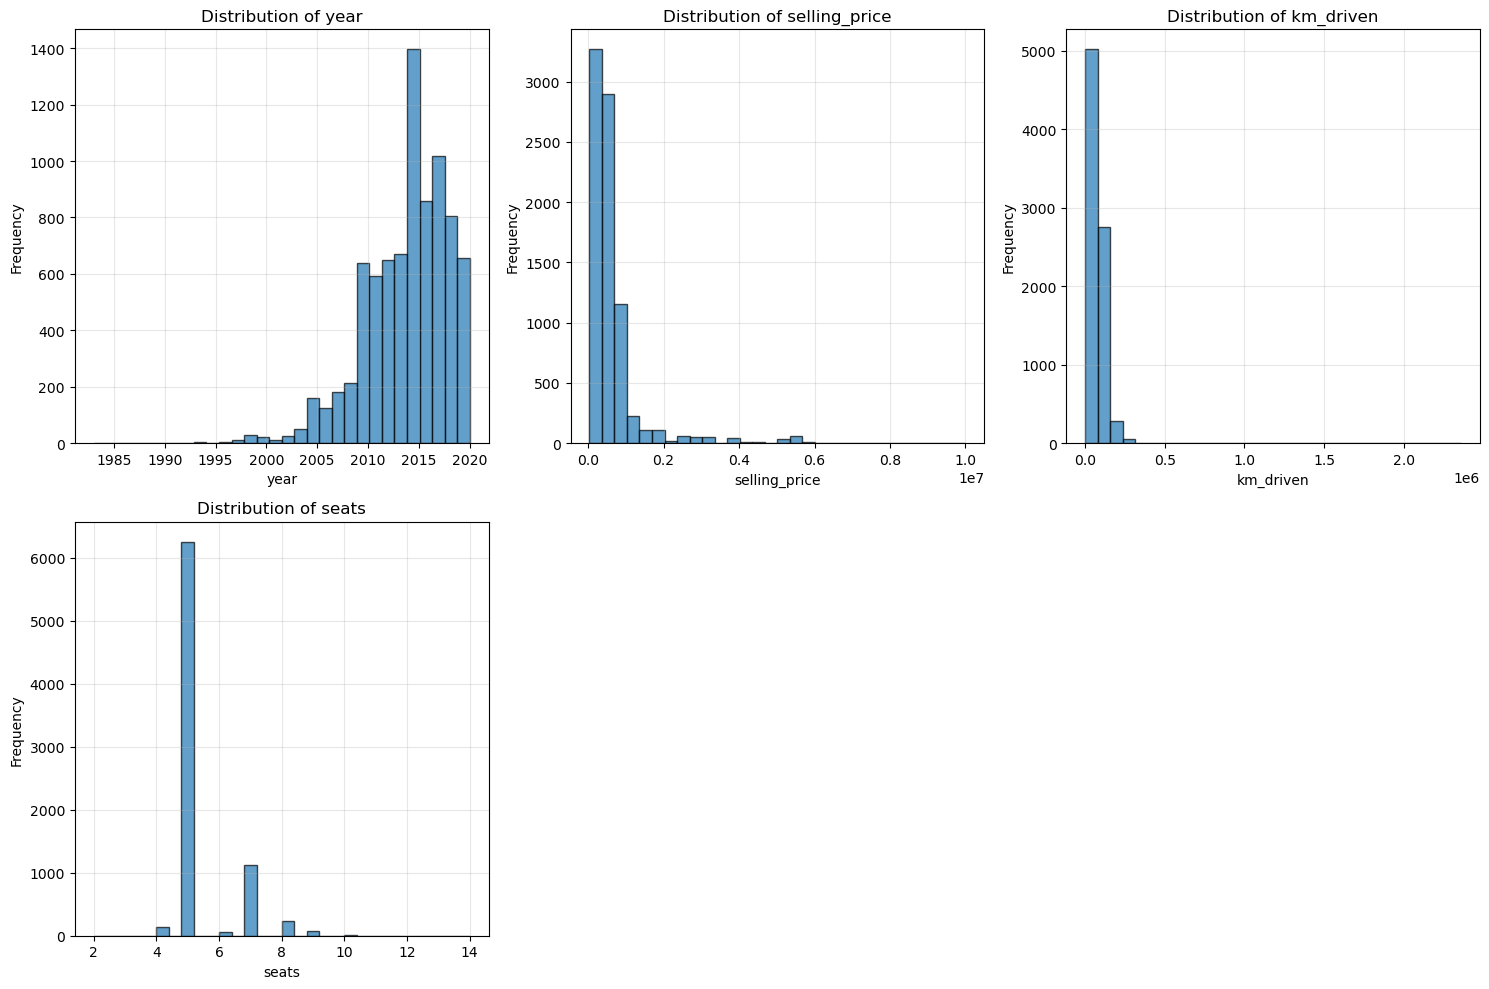

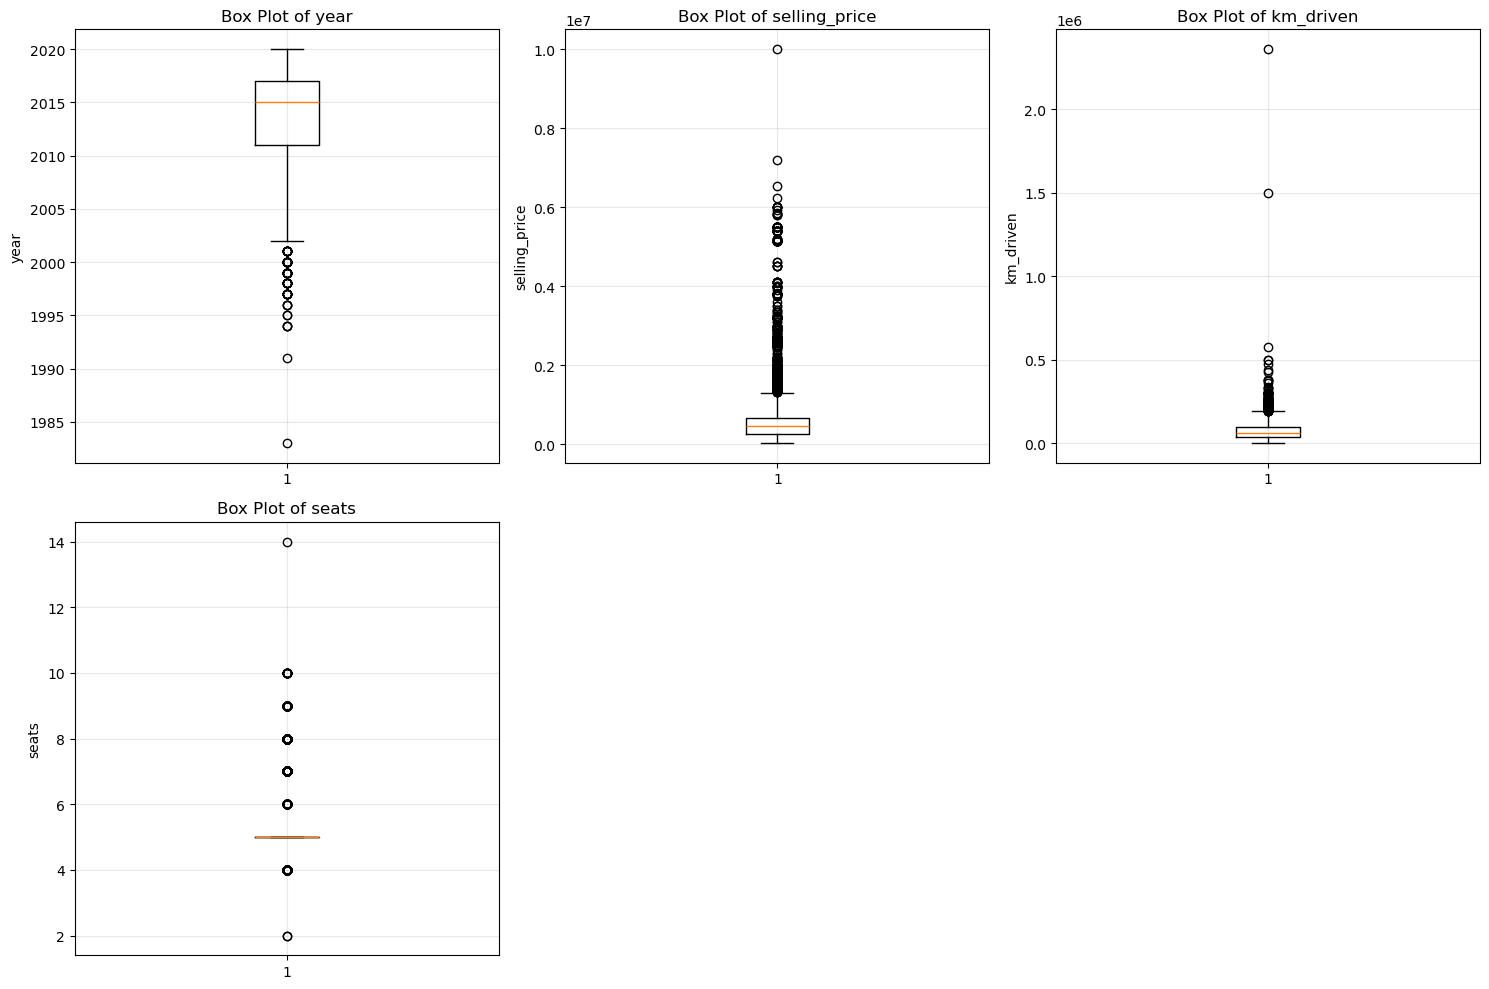

In [29]:
def distribution_analysis(df):
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Distribution metrics
    print("\nDistribution Metrics:")
    for col in numerical_cols:
        print(f"\n{col}:")
        print(f"  Skewness: {skew(df[col].dropna()):.4f}")
        print(f"  Kurtosis: {kurtosis(df[col].dropna()):.4f}")
        
        # Normality test
        if len(df[col].dropna()) >= 3:
            stat, p_value = stats.shapiro(df[col].dropna().sample(min(5000, len(df[col].dropna()))))
            print(f"  Shapiro-Wilk test p-value: {p_value:.4f}")
            print(f"  Normal distribution: {'Yes' if p_value > 0.05 else 'No'}")
    
    # Histograms
    n_cols = len(numerical_cols)
    n_rows = (n_cols + 2) // 3
    
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_cols > 1 else [axes]
    
    for idx, col in enumerate(numerical_cols):
        axes[idx].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'Distribution of {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(True, alpha=0.3)
    
    # Hide empty subplots
    for idx in range(len(numerical_cols), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Box plots
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_cols > 1 else [axes]
    
    for idx, col in enumerate(numerical_cols):
        axes[idx].boxplot(df[col].dropna())
        axes[idx].set_title(f'Box Plot of {col}')
        axes[idx].set_ylabel(col)
        axes[idx].grid(True, alpha=0.3)
    
    for idx in range(len(numerical_cols), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

distribution_analysis(df)

In [34]:
def outlier_detection(df):

    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    print("\nIQR Method (Outliers beyond 1.5 * IQR):")
    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count = len(outliers)
        outlier_percentage = (outlier_count / len(df)) * 100
        
        print(f"\n{col}:")
        print(f"  Lower bound: {lower_bound:.2f}")
        print(f"  Upper bound: {upper_bound:.2f}")
        print(f"  Outliers count: {outlier_count}")
        print(f"  Outliers percentage: {outlier_percentage:.2f}%")
    
    print("Z-Score Method (|Z-score| > 3):")
    for col in numerical_cols:
        z_scores = np.abs(stats.zscore(df[col].dropna()))
        outliers = np.sum(z_scores > 3)
        outlier_percentage = (outliers / len(df[col].dropna())) * 100
        
        print(f"\n{col}:")
        print(f"  Outliers count: {outliers}")
        print(f"  Outliers percentage: {outlier_percentage:.2f}%")


In [35]:
outlier_detection(df)


IQR Method (Outliers beyond 1.5 * IQR):

year:
  Lower bound: 2002.00
  Upper bound: 2026.00
  Outliers count: 81
  Outliers percentage: 1.00%

selling_price:
  Lower bound: -375002.50
  Upper bound: 1305001.50
  Outliers count: 600
  Outliers percentage: 7.38%

km_driven:
  Lower bound: -59500.00
  Upper bound: 192500.00
  Outliers count: 170
  Outliers percentage: 2.09%

seats:
  Lower bound: 5.00
  Upper bound: 5.00
  Outliers count: 1653
  Outliers percentage: 20.34%
Z-Score Method (|Z-score| > 3):

year:
  Outliers count: 81
  Outliers percentage: 1.00%

selling_price:
  Outliers count: 229
  Outliers percentage: 2.82%

km_driven:
  Outliers count: 72
  Outliers percentage: 0.89%

seats:
  Outliers count: 102
  Outliers percentage: 1.29%


In [36]:
def correlation_analysis(df):
    
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Pearson correlation
    print("\nPearson Correlation Matrix:")
    corr_matrix = df[numerical_cols].corr()
    print(corr_matrix)
    
    # Heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1)
    plt.title('Correlation Heatmap (Pearson)')
    plt.tight_layout()
    plt.show()
    
    # High correlations
    print("High Correlations (|r| > 0.7):")
    high_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.7:
                high_corr.append({
                    'Feature 1': corr_matrix.columns[i],
                    'Feature 2': corr_matrix.columns[j],
                    'Correlation': corr_matrix.iloc[i, j]
                })
    
    if high_corr:
        print(pd.DataFrame(high_corr))
    else:
        print("No high correlations found.")
    
    # Spearman correlation
    print("Spearman Correlation Matrix:")
    spearman_corr = df[numerical_cols].corr(method='spearman')
    print(spearman_corr)



Pearson Correlation Matrix:
                   year  selling_price  km_driven     seats
year           1.000000       0.414092  -0.418006 -0.009144
selling_price  0.414092       1.000000  -0.225534  0.041358
km_driven     -0.418006      -0.225534   1.000000  0.227336
seats         -0.009144       0.041358   0.227336  1.000000


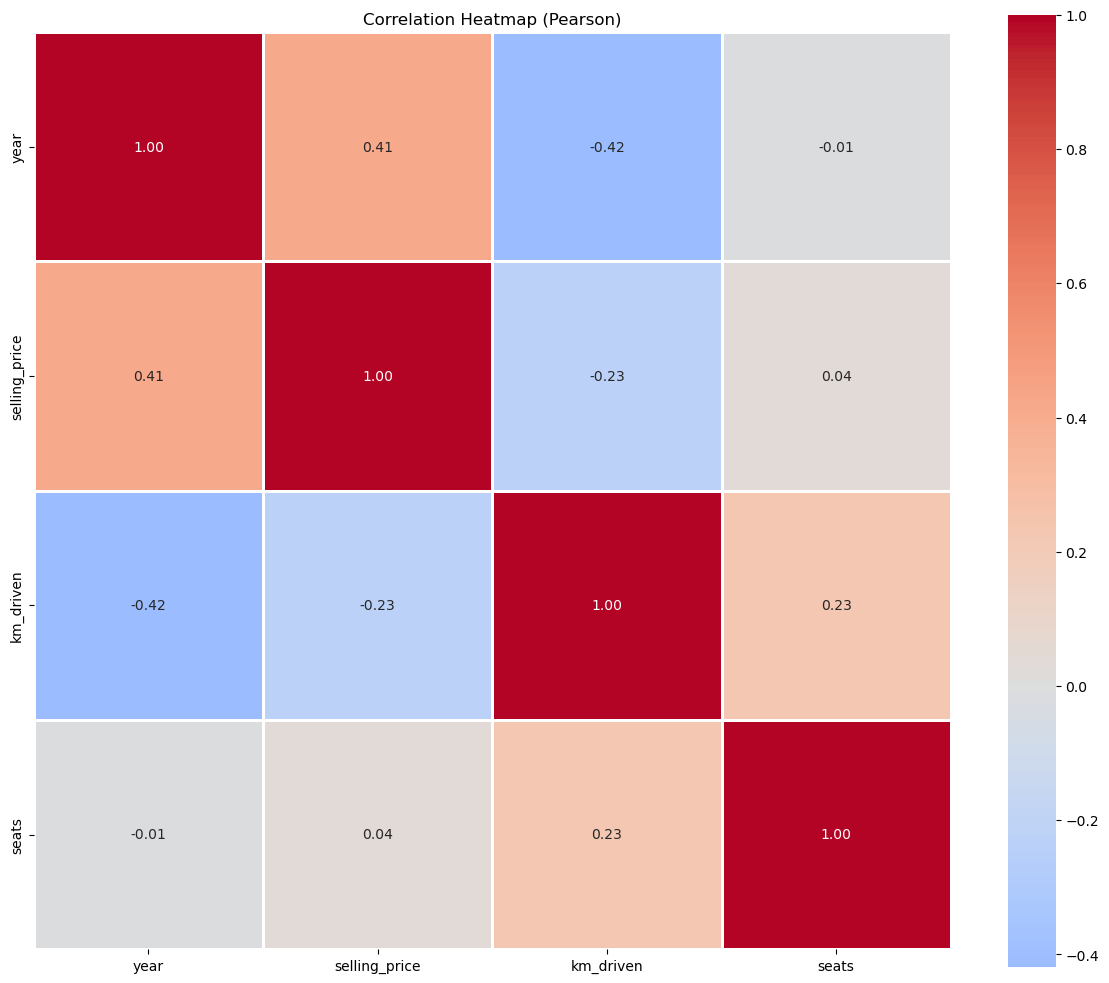

High Correlations (|r| > 0.7):
No high correlations found.
Spearman Correlation Matrix:
                   year  selling_price  km_driven     seats
year           1.000000       0.713523  -0.617792 -0.010459
selling_price  0.713523       1.000000  -0.355087  0.263143
km_driven     -0.617792      -0.355087   1.000000  0.228042
seats         -0.010459       0.263143   0.228042  1.000000


In [37]:
correlation_analysis(df)

In [44]:
def categorical_analysis(df):

    new_category_cols = ['owner', 'fuel', 'seller_type', 'transmission']
    
    # keep only columns that exist in df
    categorical_cols = [c for c in new_category_cols if c in df.columns]

    for col in categorical_cols:
        plt.figure(figsize=(10, 6))
        df[col].value_counts().plot(kind='bar', edgecolor='black', alpha=0.7)

        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

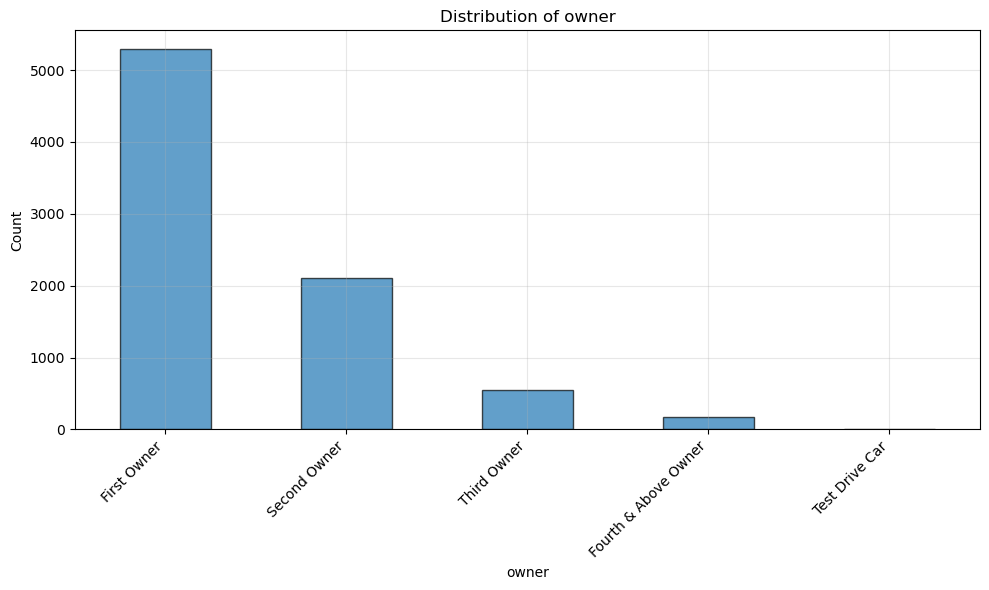

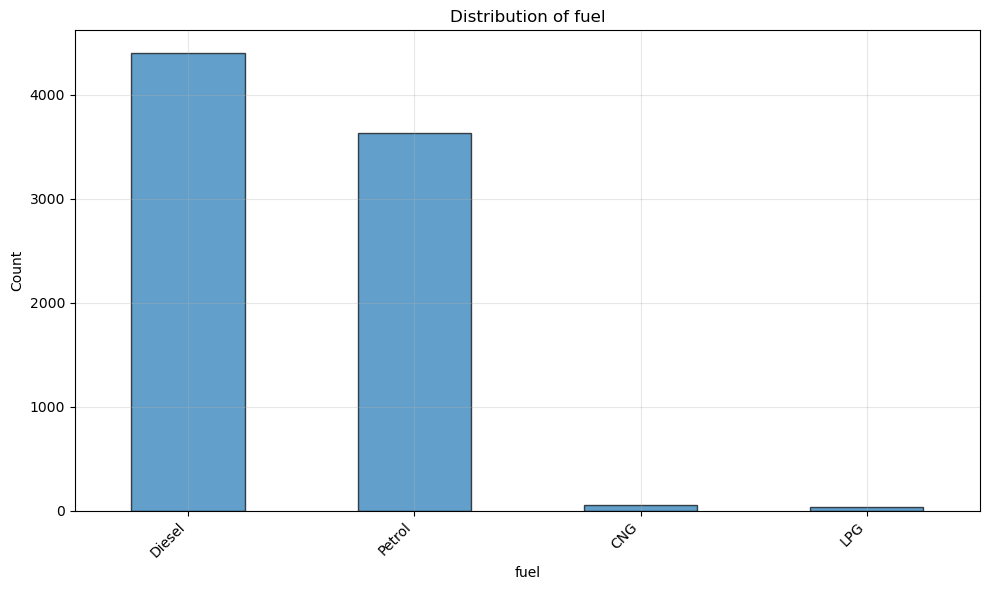

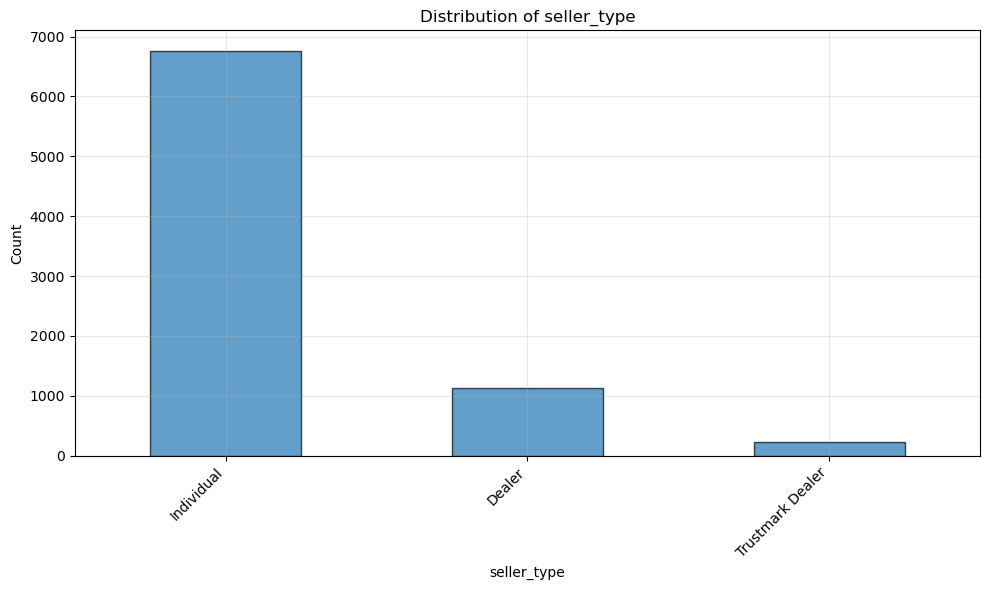

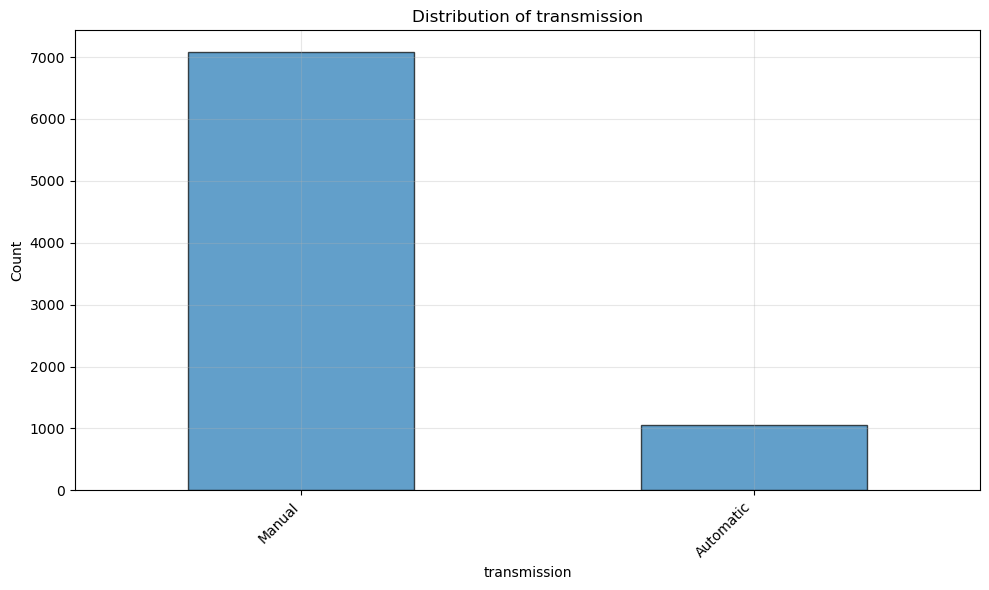

In [45]:
categorical_analysis(df)

In [46]:
def bivariate_analysis(df, target_col='selling_price'):

    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    new_category_cols = ['owner', 'fuel', 'seller_type', 'transmission']
    # keep only columns that exist in df
    categorical_cols = [c for c in new_category_cols if c in df.columns]
    
    # Numerical vs Target
    print(f"\nCorrelation with {target_col}:")
    if target_col in numerical_cols:
        correlations = df[numerical_cols].corrwith(df[target_col]).sort_values(ascending=False)
        print(correlations)
        
        # Scatter plots
        other_numerical = [col for col in numerical_cols if col != target_col]
        n_cols = len(other_numerical)
        n_rows = (n_cols + 2) // 3
        
        fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
        axes = axes.flatten() if n_cols > 1 else [axes]
        
        for idx, col in enumerate(other_numerical):
            axes[idx].scatter(df[col], df[target_col], alpha=0.5)
            axes[idx].set_xlabel(col)
            axes[idx].set_ylabel(target_col)
            axes[idx].set_title(f'{col} vs {target_col}')
            axes[idx].grid(True, alpha=0.3)
        
        for idx in range(len(other_numerical), len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Categorical vs Target
    print(f"Categorical features vs {target_col}:")
    
    for col in categorical_cols:
        print(f"\n{col}:")
        group_stats = df.groupby(col)[target_col].agg(['mean', 'median', 'std', 'count'])
        print(group_stats)
        
        # Box plot
        plt.figure(figsize=(12, 6))
        df.boxplot(column=target_col, by=col, figsize=(12, 6))
        plt.title(f'{target_col} by {col}')
        plt.suptitle('')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


Correlation with selling_price:
selling_price    1.000000
year             0.414092
seats            0.041358
km_driven       -0.225534
dtype: float64


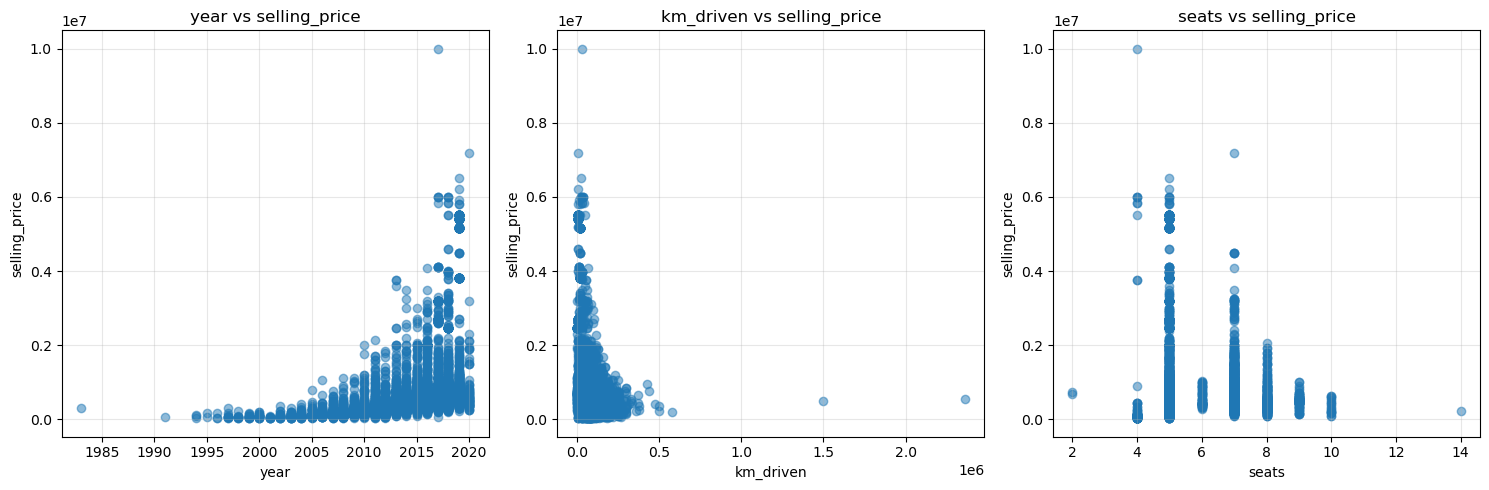

Categorical features vs selling_price:

owner:
                              mean     median           std  count
owner                                                             
First Owner           7.830864e+05   550000.0  9.319794e+05   5289
Fourth & Above Owner  2.258132e+05   170000.0  1.549900e+05    174
Second Owner          3.929645e+05   310000.0  3.264403e+05   2105
Test Drive Car        4.403800e+06  5923000.0  2.510598e+06      5
Third Owner           2.840153e+05   225000.0  2.268865e+05    555


<Figure size 1200x600 with 0 Axes>

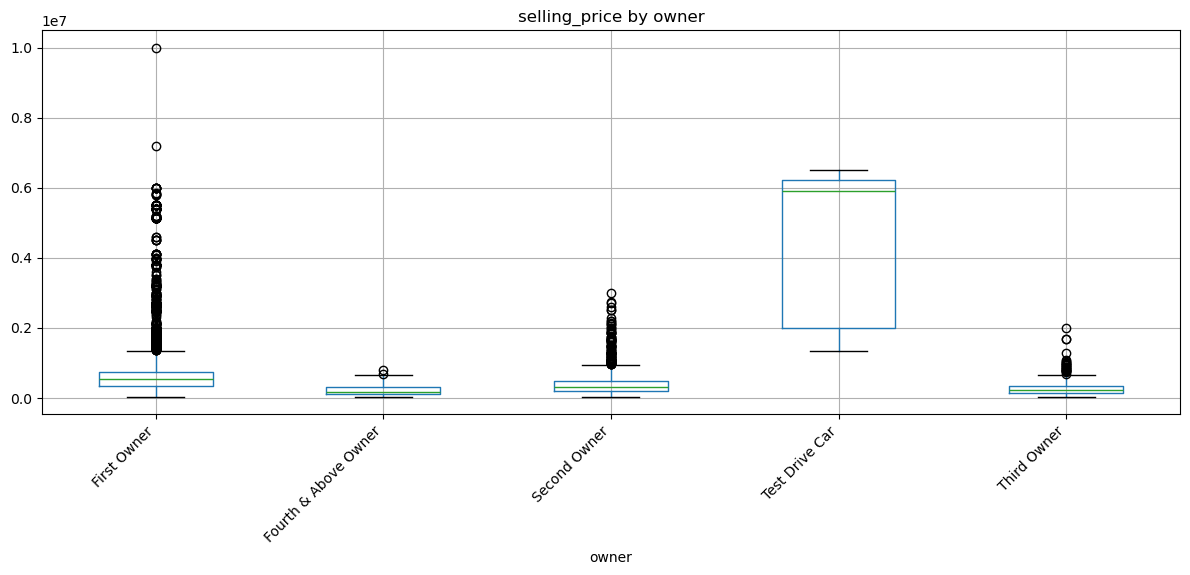


fuel:
                 mean    median            std  count
fuel                                                 
CNG     301017.491228  320000.0  111582.298949     57
Diesel  791452.921627  550000.0  908894.768774   4402
LPG     200421.052632  195500.0   84921.468199     38
Petrol  462441.061691  345000.0  624788.835690   3631


<Figure size 1200x600 with 0 Axes>

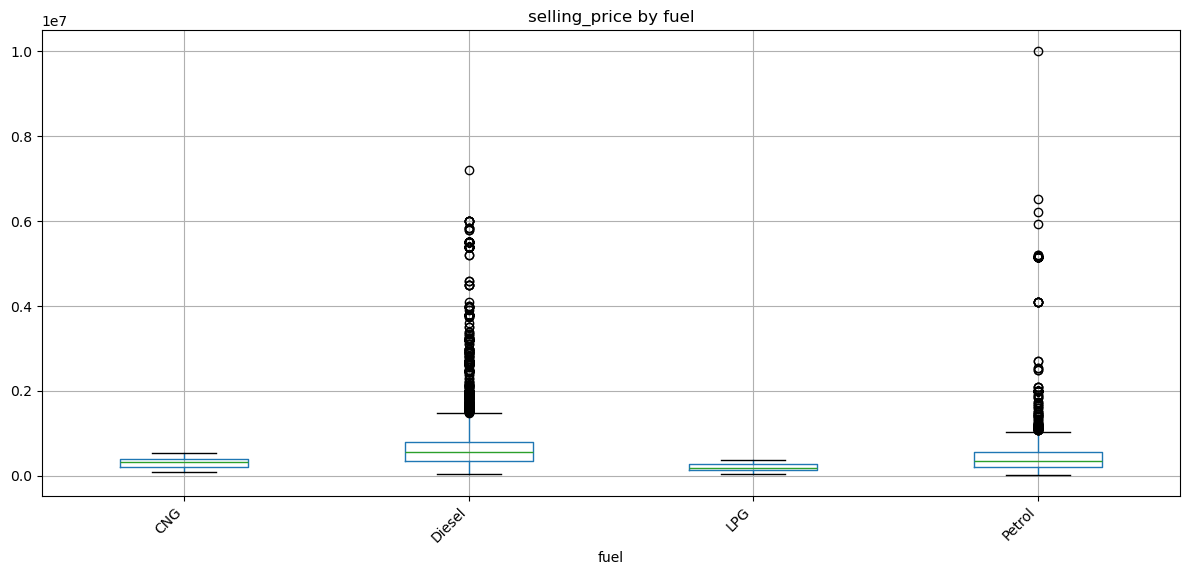


seller_type:
                          mean    median           std  count
seller_type                                                  
Dealer            1.443494e+06  690000.0  1.569286e+06   1126
Individual        4.985612e+05  400000.0  4.837797e+05   6766
Trustmark Dealer  8.018390e+05  650000.0  5.080779e+05    236


<Figure size 1200x600 with 0 Axes>

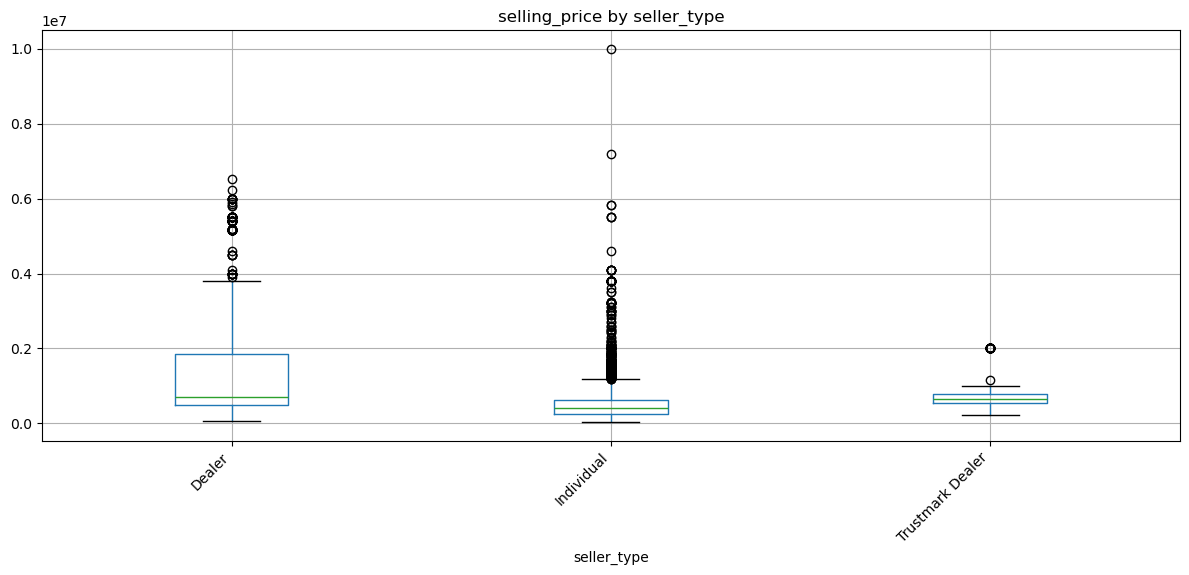


transmission:
                      mean     median           std  count
transmission                                              
Automatic     1.870828e+06  1100000.0  1.640533e+06   1050
Manual        4.554259e+05   400000.0  2.978652e+05   7078


<Figure size 1200x600 with 0 Axes>

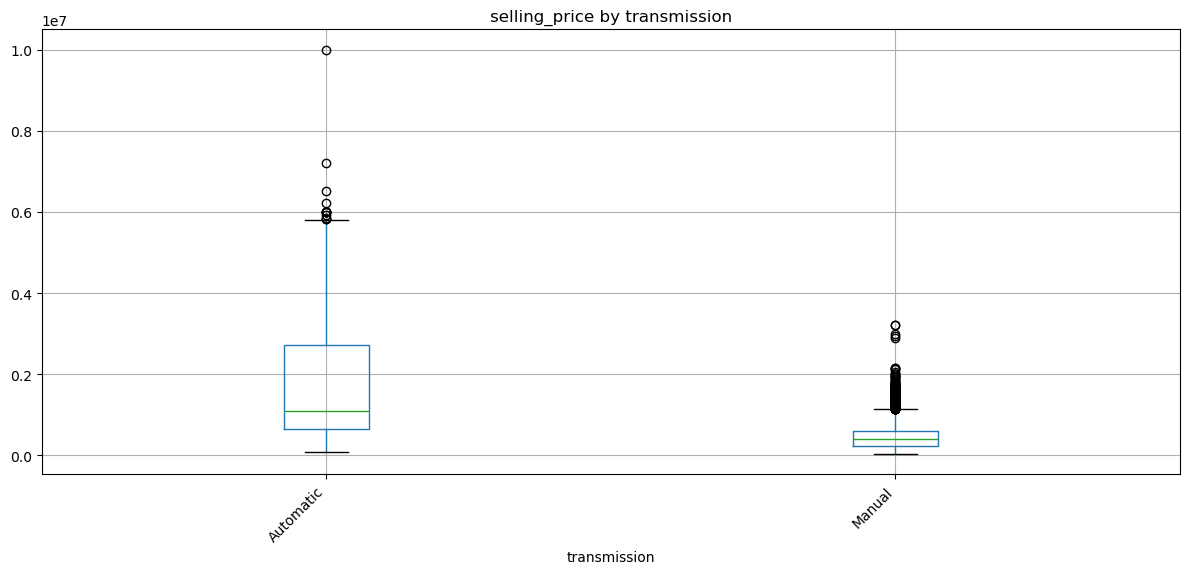

In [47]:
bivariate_analysis(df)

In [50]:
def pairplot_analysis(df, sample_size=2000):
    
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Sample data if too large
    if len(df) > sample_size:
        df_sample = df[numerical_cols].sample(sample_size)
        print(f"\nUsing sample of {sample_size} rows for pair plot")
    else:
        df_sample = df[numerical_cols]
    
    print("\nGenerating pair plot...")
    sns.pairplot(df_sample, diag_kind='kde', plot_kws={'alpha': 0.6})
    plt.tight_layout()
    plt.show()



Using sample of 2000 rows for pair plot

Generating pair plot...


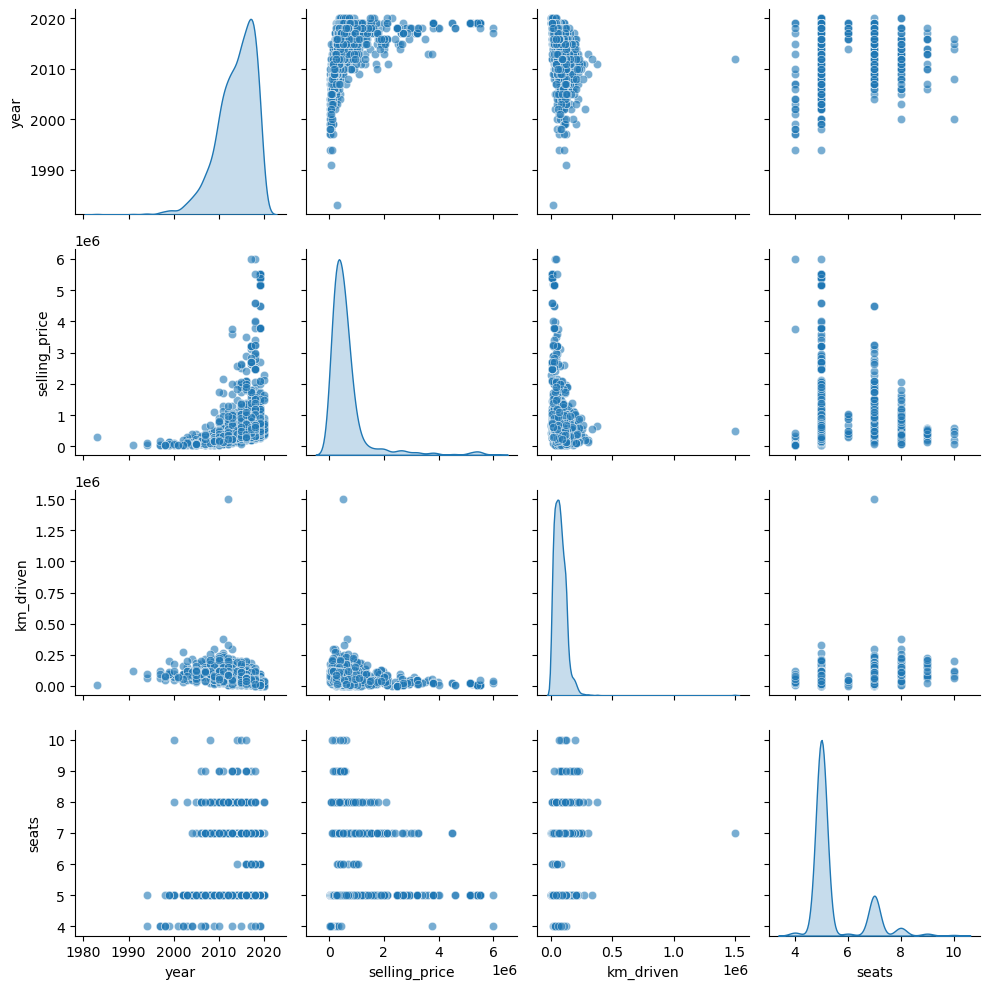

In [51]:
pairplot_analysis(df)

In [52]:
def time_series_analysis(df, time_col='year'):
    
    if time_col in df.columns:
        print(f"\nAnalyzing trends by {time_col}:")
        
        numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        numerical_cols = [col for col in numerical_cols if col != time_col]
        
        for col in numerical_cols:
            yearly_stats = df.groupby(time_col)[col].agg(['mean', 'median', 'count'])
            print(f"\n{col} by {time_col}:")
            print(yearly_stats)
            
            # Line plot
            plt.figure(figsize=(12, 6))
            yearly_stats['mean'].plot(marker='o', linewidth=2)
            plt.title(f'Average {col} by {time_col}')
            plt.xlabel(time_col)
            plt.ylabel(f'Average {col}')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()



Analyzing trends by year:

selling_price by year:
              mean    median  count
year                               
1983  3.000000e+05  300000.0      1
1991  5.500000e+04   55000.0      1
1994  8.800000e+04   99000.0      3
1995  1.075000e+05  107500.0      2
1996  8.166667e+04   42000.0      3
1997  9.018173e+04   57000.0     11
1998  7.310000e+04   63000.0     10
1999  7.583333e+04   70000.0     18
2000  9.304155e+04   83000.0     22
2001  4.849830e+04   45000.0     10
2002  9.899996e+04   75000.0     27
2003  9.563669e+04   70000.0     49
2004  1.109654e+05   90000.0     62
2005  1.411598e+05  110000.0     97
2006  1.639044e+05  140000.0    124
2007  1.777182e+05  150000.0    183
2008  2.074884e+05  170000.0    214
2009  2.264349e+05  180000.0    246
2010  2.726218e+05  220000.0    394
2011  3.237753e+05  270000.0    592
2012  3.511643e+05  300000.0    651
2013  4.600059e+05  387000.0    670
2014  5.161932e+05  450000.0    621
2015  5.966133e+05  525000.0    776
2016  6.99880

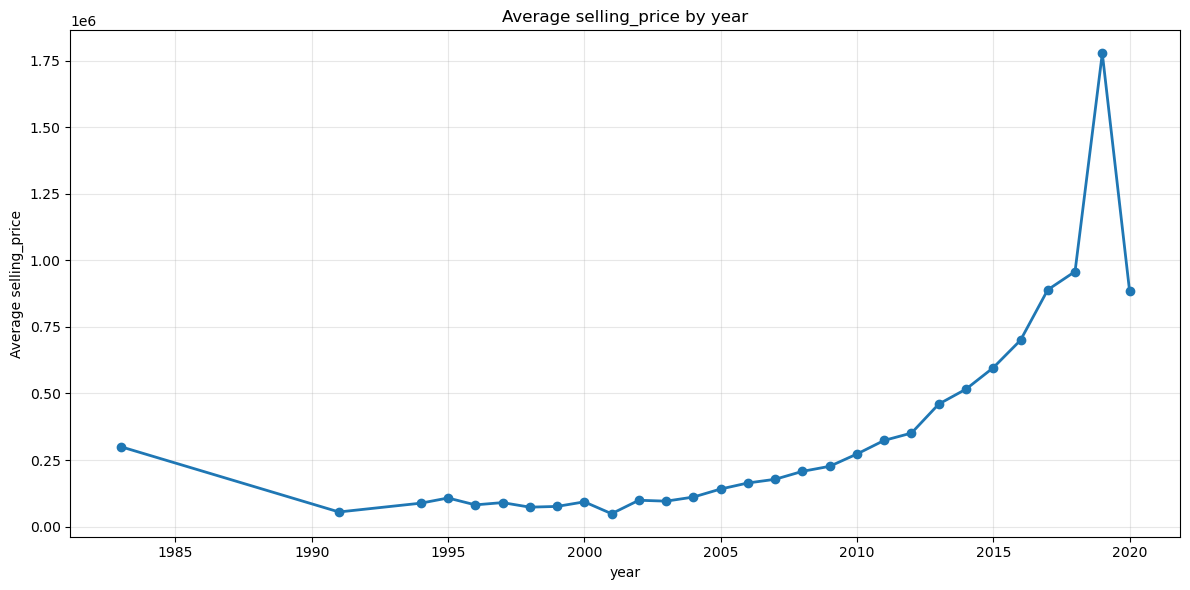


km_driven by year:
               mean    median  count
year                                
1983   10000.000000   10000.0      1
1991  120000.000000  120000.0      1
1994   86666.666667  100000.0      3
1995   80000.000000   80000.0      2
1996   35666.666667   32000.0      3
1997  100489.818182  100000.0     11
1998   68799.000000   70000.0     10
1999   93184.444444   90000.0     18
2000  106779.318182   90000.0     22
2001   58110.800000   65000.0     10
2002  102569.074074   80000.0     27
2003   92916.204082   80000.0     49
2004  100791.080645   94707.5     62
2005  100628.123711   90000.0     97
2006  104816.129032  100000.0    124
2007  113816.928962  100000.0    183
2008   97966.280374  100000.0    214
2009   98923.195122   90000.0    246
2010  101750.129442   90500.0    394
2011   96622.535473   89290.0    592
2012   95627.731183   90000.0    651
2013   85685.364179   79328.0    670
2014   78841.458937   72000.0    621
2015   71680.234536   63063.0    776
2016   58929.23515

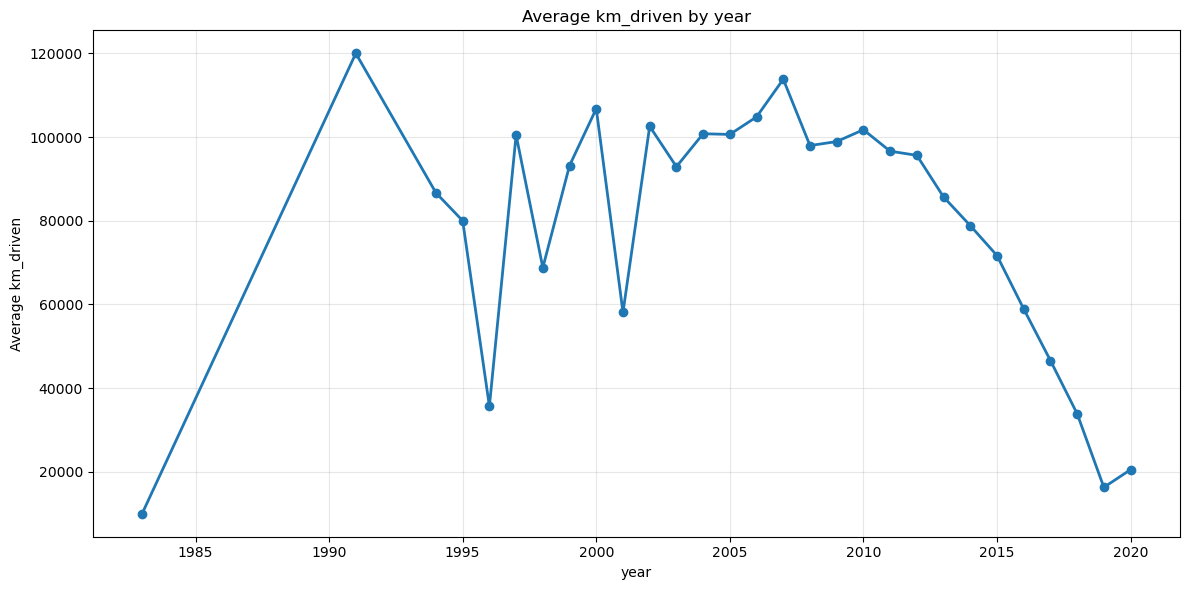


seats by year:
          mean  median  count
year                         
1983       NaN     NaN      0
1991       NaN     NaN      0
1994  4.500000     4.5      2
1995  4.000000     4.0      1
1996  4.000000     4.0      2
1997  4.666667     4.0      9
1998  4.555556     5.0      9
1999  4.500000     4.5     14
2000  5.187500     5.0     16
2001  4.333333     4.0      6
2002  5.210526     5.0     19
2003  5.081081     5.0     37
2004  4.862745     5.0     51
2005  5.394737     5.0     76
2006  5.431373     5.0    102
2007  5.381503     5.0    173
2008  5.492537     5.0    201
2009  5.367965     5.0    231
2010  5.416000     5.0    375
2011  5.445614     5.0    570
2012  5.431562     5.0    621
2013  5.600299     5.0    668
2014  5.601613     5.0    620
2015  5.598710     5.0    775
2016  5.463785     5.0    856
2017  5.312871     5.0   1010
2018  5.277916     5.0    806
2019  5.204117     5.0    583
2020  5.243243     5.0     74


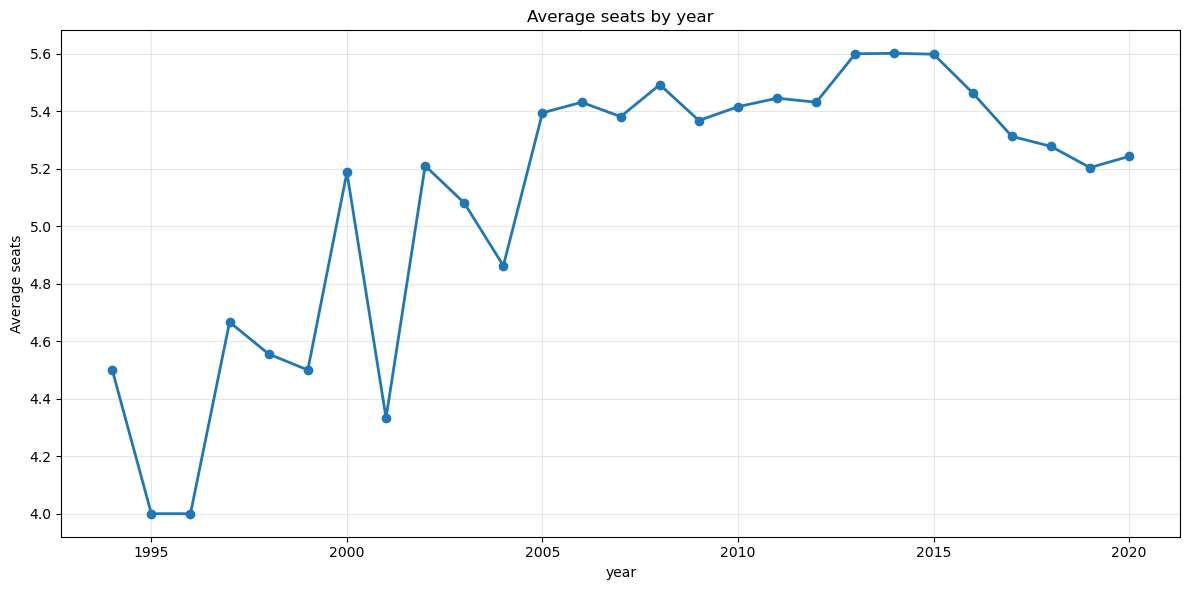

In [53]:
time_series_analysis(df)